In [14]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve

import matplotlib.pyplot as plt
import matplotlib

1.21.0
1.7.3


In [4]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return -K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, factor2, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma (DEPRECATED): RV measurement uncertainties associated with each observation; np.array of length N [cm/s]; replaced by factor2
    - factor2: inverse covariance matrix; np.array of shape (N, N) [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    fim = np.zeros((len(theta),len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed

            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter

            fim[i][j] = factor1 @ factor2 @ factor3 # matrix math magic; thanks to Arvind Gupta for the wisdom
    
    return fim

In [5]:
### priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs)
    
    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def strategy(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        fim = calculate_fim(t, sigma, theta)
        #print("FIM: ", fim)
        #print("det: ", det(fim))
        inv_fim = inv(fim)
        #print("inv: ", inv_fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #print("sigma_K, using inv: ", sigma_k)
        #sigma_ks.append(sigma_k)
        sigma_k_stable = np.sqrt(1/fim[0][0])
        #print("sigma_K, not using inv: ", sigma_k_stable)

        # np.linalg.solve is more stable than np.linalg.inv, apparently
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        
        fim = calculate_fim(t, sigma, theta)
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
    
        return sigma_k, fim

print(strategy(start=2352, n_obs=100, cadence=1, theta=test_theta, sigma_val=30)) # default to 2300


(4.2510939286821126, 4.250868319776515, 4.2510939286821126, array([[ 5.53407061e-02,  6.44610969e-01, -1.54923363e-01],
       [ 6.44610969e-01,  1.21979126e+05, -8.47760385e+03],
       [-1.54923363e-01, -8.47760385e+03,  5.50431762e+03]]))


/tmp/ipykernel_1168392/3733536849.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/3733536849.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


In [6]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    return rv

In [7]:
# arbitrary row, yellow streak column
cadence = 3.6
n_obs = 13

print(strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)) # default to 2300



(11.689366270383733, 11.64272007897692, 11.689366270383733, array([[7.37719202e-03, 6.61379883e-01, 1.05930272e-01],
       [6.61379883e-01, 1.21700545e+04, 2.73950843e+03],
       [1.05930272e-01, 2.73950843e+03, 6.97509761e+02]]))


/tmp/ipykernel_1168392/3733536849.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/3733536849.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


/tmp/ipykernel_1168392/3733536849.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/3733536849.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[7.36855953e-03 6.50322682e-01 1.07135124e-01]
 [6.50322682e-01 1.21891066e+04 2.74333980e+03]
 [1.07135124e-01 2.74333980e+03 6.98361753e+02]]
sigma_k using linalg.inv:  11.692230299308822
sigma_k using linalg.solve:  11.692230299308822
sigma_k using 1/sqrt(FIM_ii):  11.649537980408574


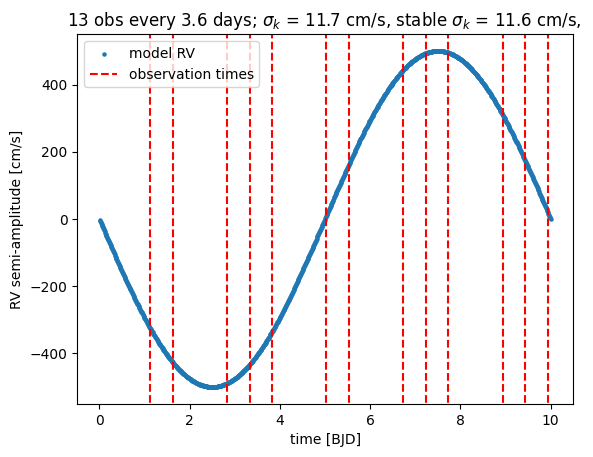

In [8]:
### strategy
cadence = 3.6
n_obs = 13

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.savefig('plots/strategy1.pdf', format='pdf')
plt.legend()
plt.show()

/tmp/ipykernel_1168392/3733536849.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/3733536849.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 3.88853634e-02 -5.83855879e-01  8.15682631e-03]
 [-5.83855879e-01  4.62990383e+04  1.01017639e+03]
 [ 8.15682631e-03  1.01017639e+03  3.94818919e+03]]
sigma_k using linalg.inv:  5.071642817867032
sigma_k using linalg.solve:  5.071642817867032
sigma_k using 1/sqrt(FIM_ii):  5.071155397706453


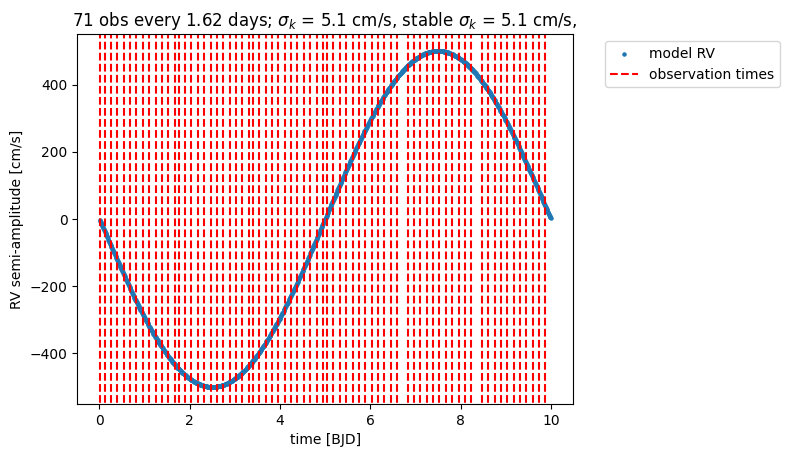

In [9]:
### strategy
cadence = 1.62
n_obs = 71

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.savefig('plots/strategy2.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

/tmp/ipykernel_1168392/3733536849.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/3733536849.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 4.05739573e-02 -5.66360252e-01 -1.10248189e-02]
 [-5.66360252e-01  4.79858354e+04  6.85021908e+02]
 [-1.10248189e-02  6.85021908e+02  4.00085618e+03]]
sigma_k using linalg.inv:  4.964918292305593
sigma_k using linalg.solve:  4.964918292305593
sigma_k using 1/sqrt(FIM_ii):  4.964509158119651


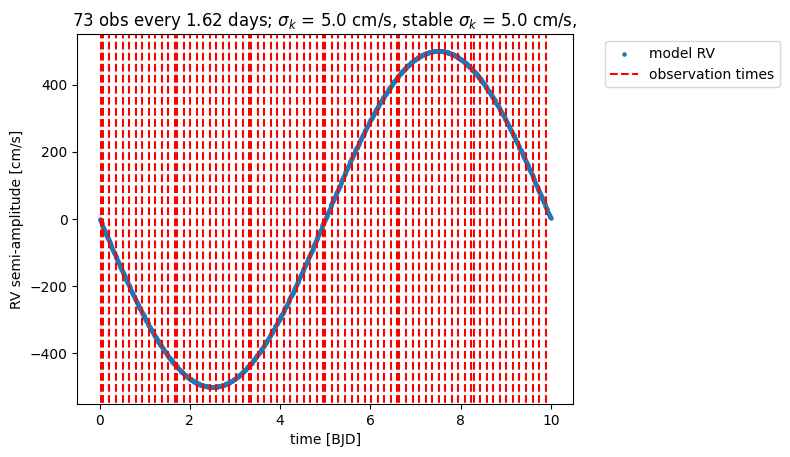

In [10]:
### strategy
cadence = 1.62
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.savefig('plots/strategy3.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

FIM:  [[ 4.03486980e-05 -8.29864539e+00  2.39499590e-01]
 [-8.29864539e+00  2.03845749e+06 -9.59723074e+04]
 [ 2.39499590e-01 -9.59723074e+04  8.00136300e+03]]
sigma_k using linalg.inv:  863339.9953537022
sigma_k using linalg.solve:  863339.9953537022
sigma_k using 1/sqrt(FIM_ii):  157.42918145396058


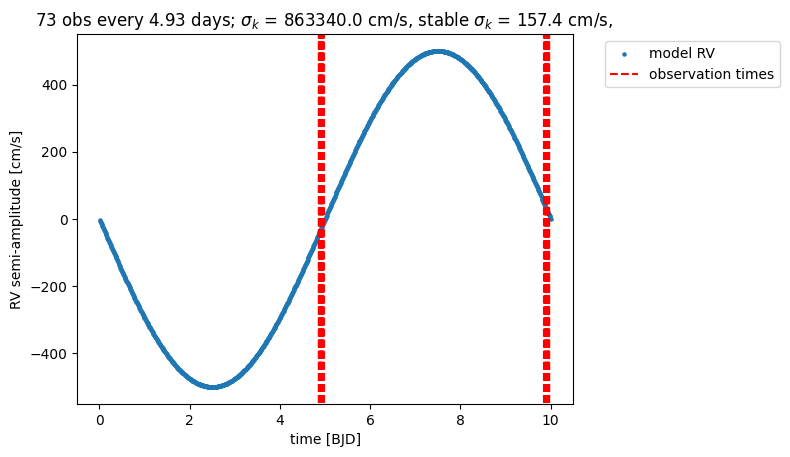

In [11]:
### strategy
cadence = 4.93
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Let's explore the full parameter space of (n_obs, cadence), so that we can plot sensitivity maps

In [12]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)
sigma_ks = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

#with tqdm.tqdm(total=100) as pbar:
for enum_i, i in enumerate(n_observations):
    for enum_j, j in enumerate(cadences):
        #print(i, j)
        sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)

        sigma_ks[enum_i][enum_j] = sigma_k
        sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
        sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

/tmp/ipykernel_1168392/3733536849.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/3733536849.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


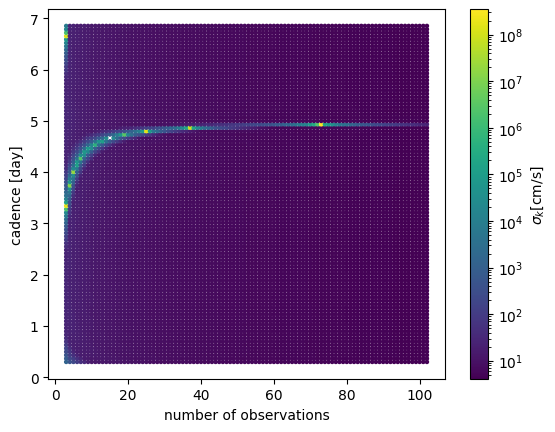

In [18]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("plots/n_obs-cadence-sigma_k-white.pdf", format="pdf")
plt.show()

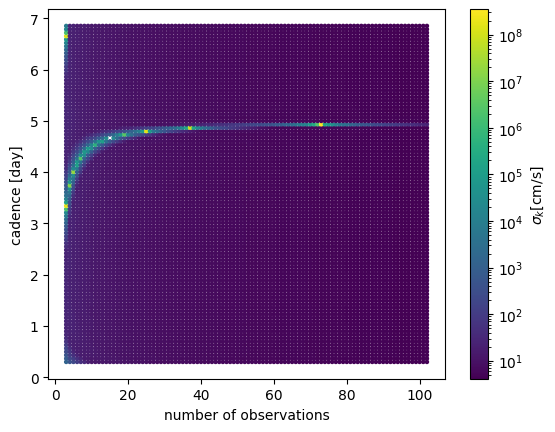

In [19]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("plots/n_obs-cadence-sigma_k-solve-white.pdf", format="pdf")
plt.show()

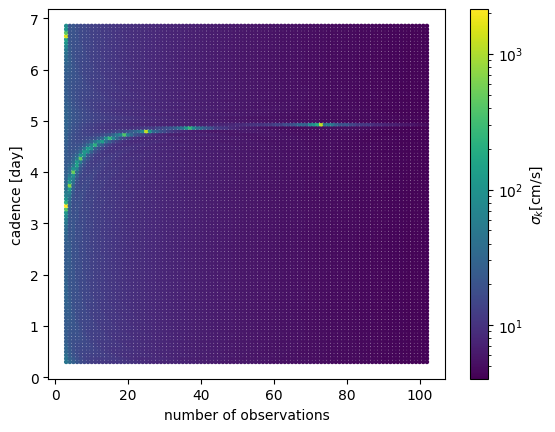

In [20]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.savefig("plots/n_obs-cadence-sigma_k-stable-white.pdf", format="pdf")
plt.show()

Let's marginalize over different starts time to get a more smoothed picture

In [16]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)

#with tqdm.tqdm(total=100) as pbar:
starts = np.linspace(2300, 2300+test_P, 200)
sigma_ks_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve_all = np.ones(dim**2).reshape((dim,dim))
    
for start in starts: 
    sigma_ks = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

    for enum_i, i in enumerate(n_observations):
        for enum_j, j in enumerate(cadences):
            try:
                sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
            except Exception as e:
                print(e, ", culprit: ", start, i, j)

            sigma_ks[enum_i][enum_j] = sigma_k
            sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
            sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

            sigma_ks_all += sigma_ks
            sigma_ks_stable_all += sigma_ks_stable
            sigma_ks_solve_all += sigma_ks_solve

/tmp/ipykernel_185059/4038332269.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_185059/4038332269.py:80: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


Singular matrix , culprit:  2301.5577889447236 3 2.814141414141414
Singular matrix , culprit:  2301.608040201005 49 4.865151515151514
Singular matrix , culprit:  2305.929648241206 5 2.814141414141414
Singular matrix , culprit:  2306.834170854271 4 5.7914141414141405
Singular matrix , culprit:  2308.7939698492464 13 3.9388888888888887
Singular matrix , culprit:  2309.64824120603 3 6.783838383838384
Singular matrix , culprit:  2309.9497487437184 25 4.402020202020202


In [2]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve_all, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using np.linalg.solve")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()

NameError: name 'np' is not defined

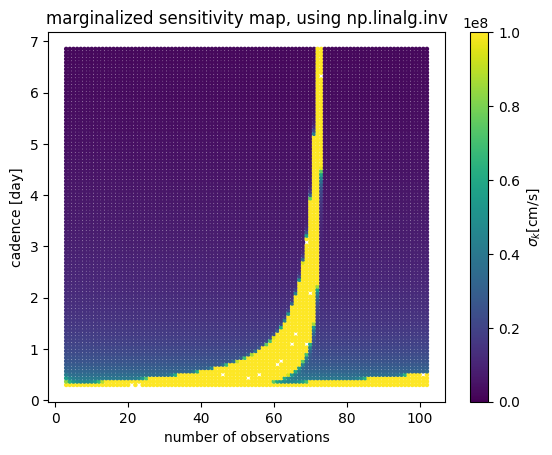

In [18]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_all, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using np.linalg.inv")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()

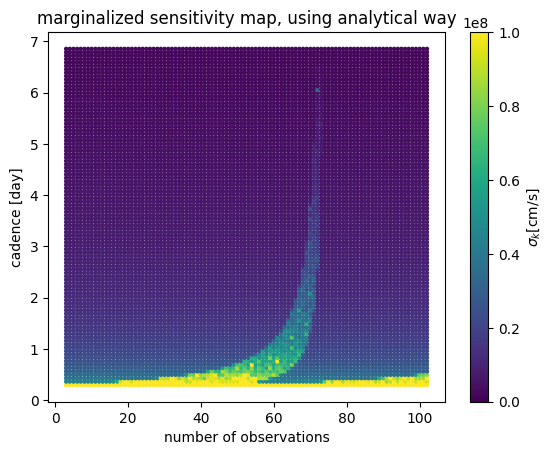

In [19]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable_all, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using analytical way")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()